In [10]:
!unzip /content/diabetes_012_health_indicators_BRFSS2015.csv.zip

Archive:  /content/diabetes_012_health_indicators_BRFSS2015.csv.zip
replace diabetes_012_health_indicators_BRFSS2015.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: adg
error:  invalid response [adg]
replace diabetes_012_health_indicators_BRFSS2015.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import shap

In [12]:
# Load the dataset
file_path = '/content/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

In [13]:
# Separate features and target
X = data.drop('Diabetes_012', axis=1).values
y = data['Diabetes_012'].values

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# Define the Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 32
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

train_auto_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(32).shuffle(buffer_size=1024)
history_autoencoder = autoencoder.fit(train_auto_dataset, epochs=30, verbose=1)

Epoch 1/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.6845
Epoch 2/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6106
Epoch 3/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6089
Epoch 4/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6074
Epoch 5/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6070
Epoch 6/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.6069
Epoch 7/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6067
Epoch 8/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.6076
Epoch 9/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6073
Epoch 10/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.6072
Epoch 11/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6075
Epoch 12/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.6070
Epoch 13/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.6069
Epoch 14/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - 

In [17]:
# Extract the encoder model
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Build the classifier
encoded_input = layers.Input(shape=(16,))
classifier_layer = layers.Dense(32, activation='relu')(encoded_input)
classifier_layer = layers.Dense(16, activation='relu')(classifier_layer)
classifier_layer = layers.Dense(3, activation='softmax')(classifier_layer)
classifier = models.Model(inputs=encoded_input, outputs=classifier_layer)
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Prepare encoded data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).batch(32)

# Train the classifier
history_classifier = classifier.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=1)

# Evaluate the model
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)

train_accuracy = accuracy_score(y_train, np.argmax(classifier.predict(X_train_encoded), axis=1))
test_accuracy = accuracy_score(y_test, y_pred_classes)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

16028/16028 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Epoch 1/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.5109 - loss: 1.0083 - val_accuracy: 0.5686 - val_loss: 0.8900
Epoch 2/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.5736 - loss: 0.8784 - val_accuracy: 0.5836 - val_loss: 0.8505
Epoch 3/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.5929 - loss: 0.8406 - val_accuracy: 0.5985 - val_loss: 0.8356
Epoch 4/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.6055 - loss: 0.8172 - val_accuracy: 0.6107 - val_loss: 0.8139
Epoch 5/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.6131 - loss: 0.8027 - val_accuracy: 0.6026 - val_loss: 0.8255
Epoch 6/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.6203 - loss: 0.7904 - val_accuracy: 0.6234 - val_loss: 0.7822
Epoch 7/30
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6232 - loss: 0.7809 - val_accuracy: 0.6305

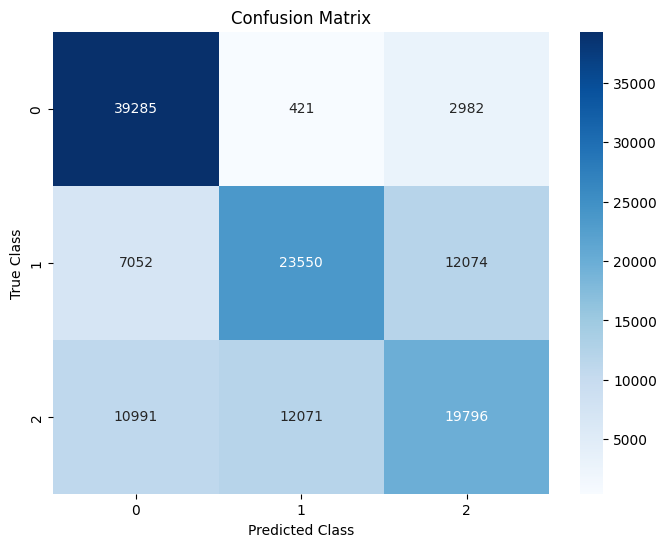

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

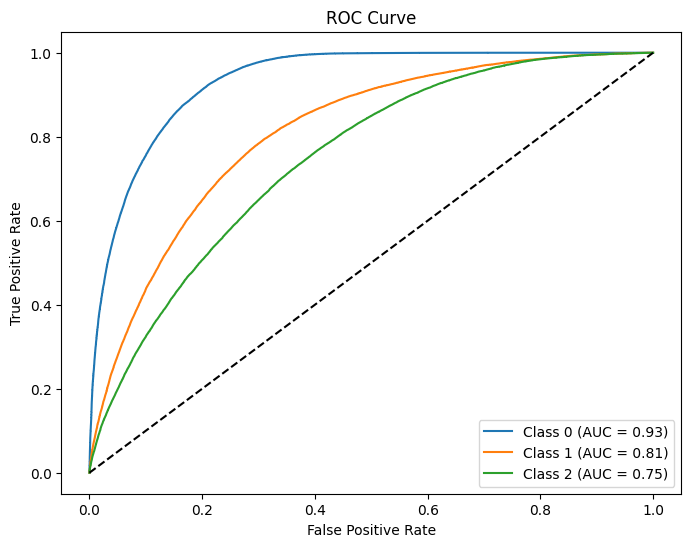

In [20]:
# ROC Curve and AUC
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve((y_test==i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Explaining Class 0 with SHAP:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

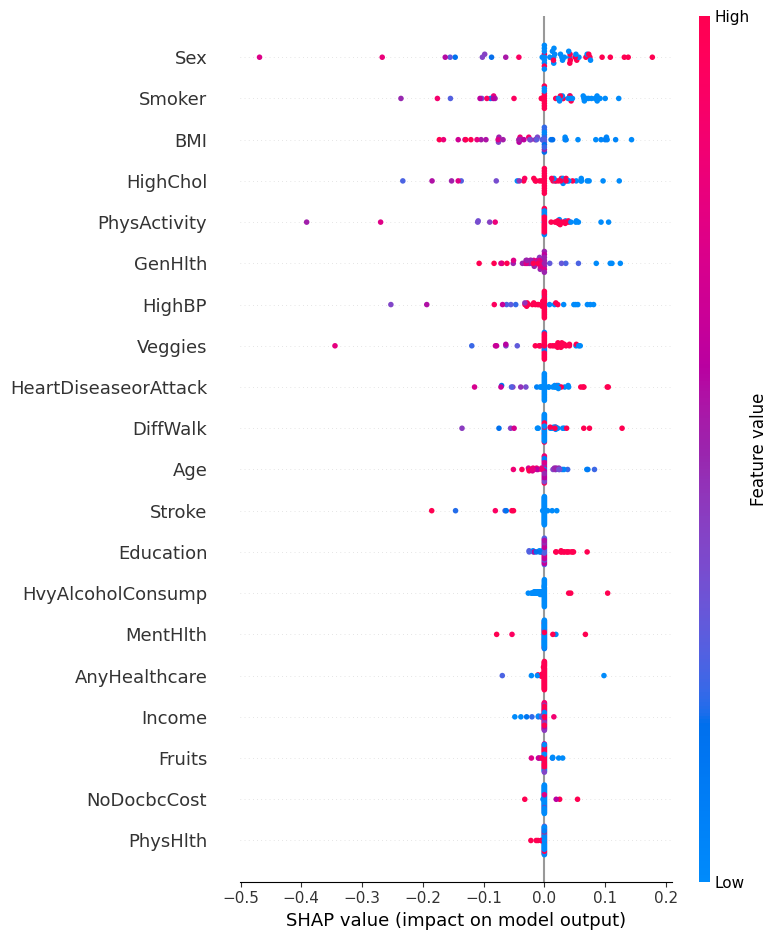


Explaining Class 1 with SHAP:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

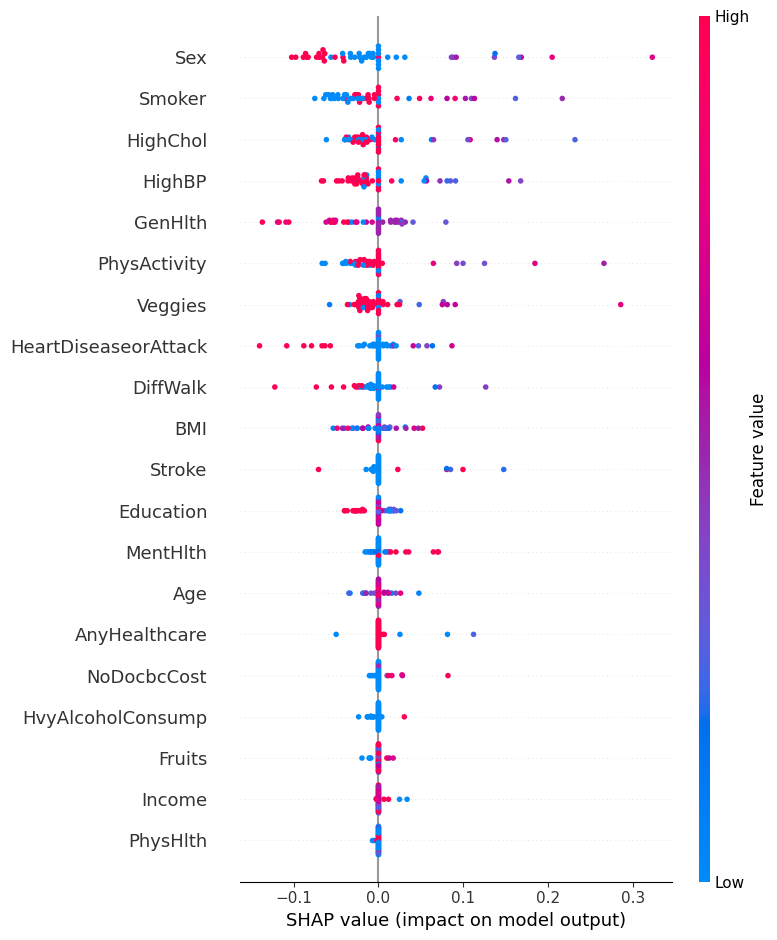


Explaining Class 2 with SHAP:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

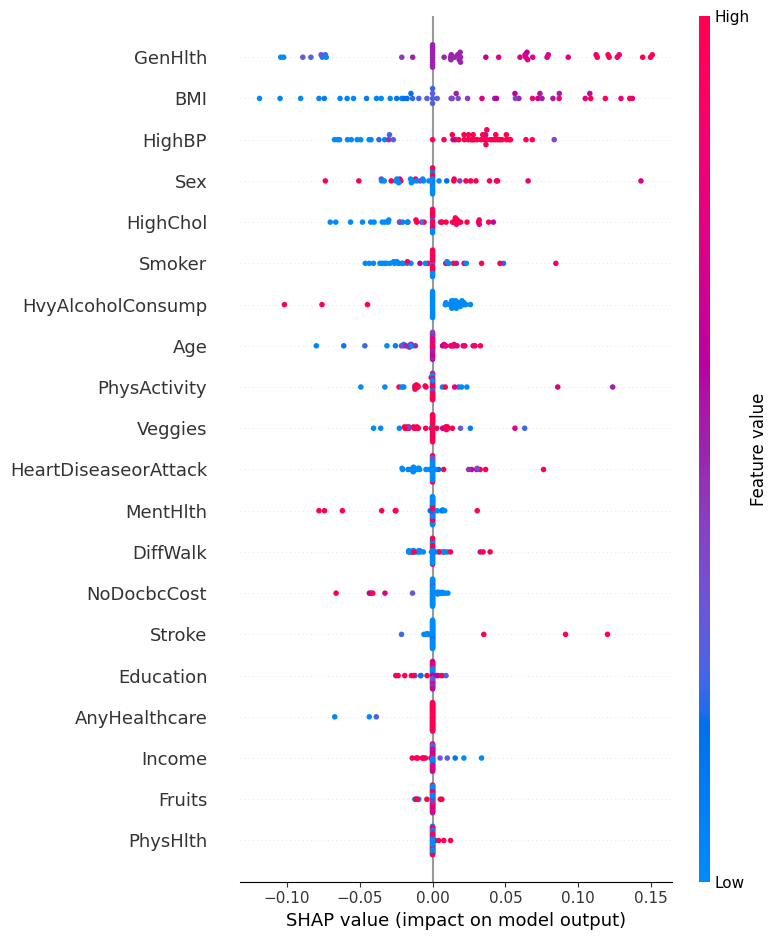

In [25]:
# --- SHAP Value Analysis ---
feature_names = data.drop('Diabetes_012', axis=1).columns.tolist()
# Re-run encoding for raw input (not encoded)
def get_class_predictions(full_model, class_ind, input_data):
    # Input data must first pass through encoder and then classifier
    encoded = encoder.predict(input_data)
    preds = classifier.predict(encoded)
    return preds[:, class_ind]

# Make sure X_train and X_test are numpy arrays
X_train = X_train if isinstance(X_train, np.ndarray) else X_train.values
X_test = X_test if isinstance(X_test, np.ndarray) else X_test.values

# Background and test samples
background = X_train[:100]
test_samples = X_test[:50]

num_classes = 3  # Classes are 0, 1, 2

for class_ind in range(num_classes):
    print(f"\nExplaining Class {class_ind} with SHAP:")

    # Define explainer for each class separately
    explainer = shap.KernelExplainer(lambda x: get_class_predictions((encoder, classifier), class_ind, x), background)

    shap_values = explainer.shap_values(test_samples)

    print(f"SHAP values shape for class {class_ind}: {np.array(shap_values).shape}")

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, test_samples, feature_names=feature_names)